In [1]:
import os
import cv2
import torch
import torchmetrics
import albumentations as A
import albumentations.pytorch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler


torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Параметры обучения

In [2]:
batch_size = 16
epochs = 10
lr = 0.001
betas=(0.9, 0.999)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
use_amp = True
validate = False
save_weights = True
save_path = f"./weights/light_weights_b{batch_size}_ep{epochs}.pt"
weight_path = f"./weights/light_weights_b{batch_size}_ep{epochs}.pt"

In [3]:
DATASET_IMAGES_PATH = "./Datasets/segmentation_full_body_tik_tok_2615_img/images/"
DATASET_MASKS_PATH = "./Datasets/segmentation_full_body_tik_tok_2615_img/masks/"
traspose_size = (286, 286)

Подготовка датасета

In [4]:
transforms = A.Compose([
    A.Resize(*traspose_size),
    albumentations.pytorch.transforms.ToTensorV2()
])

In [5]:
class SegmentationDataset(torch.utils.data.Dataset):
	def __init__(self, imagePaths, maskPaths, transforms, device):
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
		self.device = device

		self.images_filenames = sorted(os.listdir(self.imagePaths))

	def __len__(self):
		return len(self.images_filenames)

	def __getitem__(self, idx):
		image_filename = self.images_filenames[idx]
		image = cv2.imread(os.path.join(self.imagePaths, image_filename), cv2.IMREAD_COLOR)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(os.path.join(self.maskPaths, image_filename), cv2.IMREAD_COLOR)[:,:,0:1]
		image = image.astype(np.float32)/255.0
		mask = mask.astype(np.float32)/255.0
		if self.transforms is not None:
			transformed = self.transforms(image=image, mask=mask)
			image = transformed["image"]
			mask = transformed["mask"]
			mask = np.transpose(mask, (2,0,1))
		return image.to(self.device), mask.to(self.device)

In [6]:
dataset = SegmentationDataset(DATASET_IMAGES_PATH, DATASET_MASKS_PATH, transforms, device)
train_len = int(len(dataset)*0.8)
validation_len =int((len(dataset)-train_len)*0.8)

In [7]:
train_dataset, valid_test = torch.utils.data.random_split(dataset, (train_len, len(dataset)-train_len))
validation_dataset, test_dataset = torch.utils.data.random_split(valid_test, (validation_len, len(valid_test)-validation_len))

Визуализация датасета

In [8]:
def visualize(dataset, samples=5):
    for i in range(0, samples*100, 100):
        figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
        image, mask = dataset[i]
        image = image.cpu().permute(1, 2, 0)
        mask = mask.cpu().permute(1, 2, 0)
        ax[0].imshow(image, cmap="gray")
        ax[1].imshow(mask, cmap="gray")
        ax[0].set_axis_off()
        ax[1].set_axis_off()

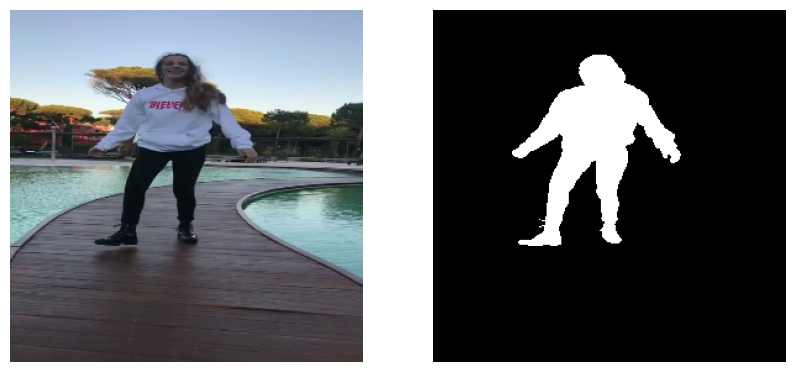

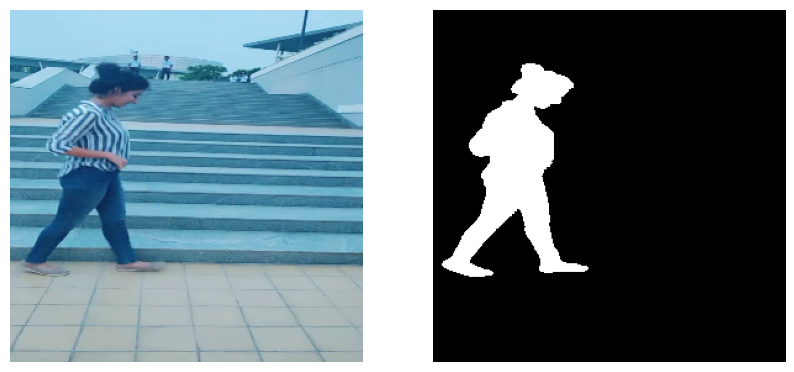

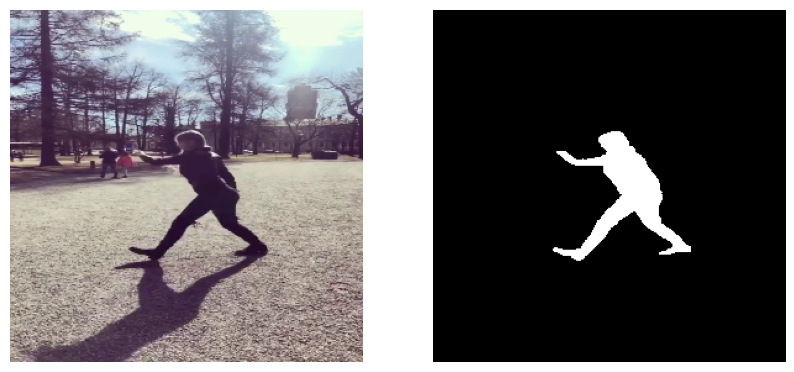

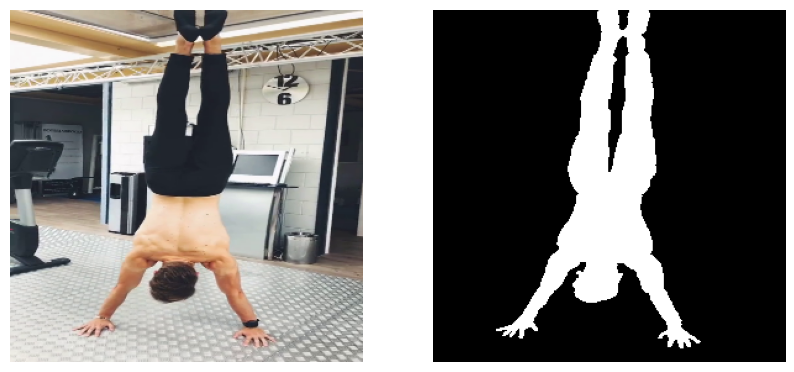

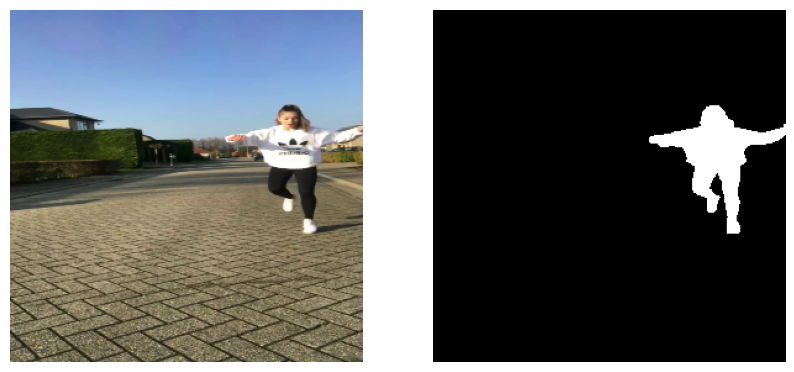

In [9]:
visualize(train_dataset)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           shuffle=True,
                                           batch_size=batch_size,
                                           drop_last=True)

validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                           shuffle=True,
                                           batch_size=batch_size,
                                           drop_last=True) 

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           shuffle=True,
                                           batch_size=batch_size,
                                           drop_last=True)


Архитектура сети

In [11]:
class CNA(torch.nn.Module):
    def __init__(self, in_nc, out_nc, stride=1):
        super().__init__()
        
        self.conv = torch.nn.Conv2d(in_nc, out_nc, 3, stride=stride, padding=1, bias=False)
        self.norm = torch.nn.BatchNorm2d(out_nc)
        self.act = torch.nn.GELU()
    
    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        out = self.act(out)
        
        return out

In [12]:
class UnetBlock(torch.nn.Module):
    def __init__(self, in_nc, inner_nc, out_nc, inner_block=None):
        super().__init__()
        
        self.conv1 = CNA(in_nc, inner_nc, stride=2)
        self.conv2 = CNA(inner_nc, inner_nc)
        self.inner_block = inner_block
        self.conv3 = CNA(inner_nc, inner_nc)
        self.conv_cat = torch.nn.Conv2d(inner_nc+in_nc, out_nc, 3, padding=1)
        
    def forward(self, x):
        _,_,h,w = x.shape
        
        inner = self.conv1(x)
        inner = self.conv2(inner)
        if self.inner_block is not None:
            inner = self.inner_block(inner)
        inner = self.conv3(inner)
        
        # inner = F.upsample(inner, size=(h,w), mode='bilinear')
        inner = F.interpolate(inner, size=(h,w), mode='bilinear')
        inner = torch.cat((x, inner), axis=1)
        out = self.conv_cat(inner)
        
        return out

In [13]:
class LightUnet(torch.nn.Module):
    def __init__(self, in_nc=1, nc=32, out_nc=1, num_downs=1):
        super().__init__()
        
        self.cna1 = CNA(in_nc, nc)
        self.cna2 = CNA(nc, nc)
        
        unet_block = None
        for i in range(num_downs):
            unet_block = UnetBlock(8*nc, 8*nc, 8*nc, unet_block)
        unet_block = UnetBlock(4*nc, 8*nc, 4*nc, unet_block)
        unet_block = UnetBlock(2*nc, 4*nc, 2*nc, unet_block)
        self.unet_block = UnetBlock(nc, 2*nc, nc, unet_block)
        
        self.cna3 = CNA(nc, nc)
        
        self.conv_last = torch.nn.Conv2d(nc, out_nc, 3, padding=1)

    def forward(self, x):
        out = self.cna1(x)
        out = self.cna2(out)
        out = self.unet_block(out)
        out = self.cna3(out)
        out = self.conv_last(out)
        
        return out

Вспомогательные функции

In [14]:
def crop(a, b):
    indent = (a.shape[2] - b.shape[2])//2
    return a[:, :, indent:a.shape[2]-indent, indent:a.shape[2]-indent]

In [15]:
def draw_crop(a, b):
    indent = (a.shape[2] - b.shape[2])//2
    return a[:, indent:a.shape[2]-indent, indent:a.shape[2]-indent]

In [16]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
def evaluate(dataloader, model, metric_fn, device):
    preds = torch.Tensor().to(device)
    masks = torch.Tensor().to(device)
    model.eval()
    with torch.no_grad():
        for img, mask in (pbar := tqdm(dataloader)):
            pred = model(img)
            preds = torch.cat((preds, pred), 1)
            masks = torch.cat((masks, crop(mask, pred)), 1)
            pbar.set_description(f'evaluation: ')
    model.train()
    metric = metric_fn(F.sigmoid(preds), masks)
    return metric

In [18]:
def train_one_epoch(dataloader,
                    model,
                    optimizer,
                    scaler,
                    loss_fn,
                    metric_fn,
                    use_amp=False):
                    
    for img, mask in (pbar := tqdm(dataloader)):
        optimizer.zero_grad()

        with autocast(use_amp):
            pred = model(img)
            loss = loss_fn(pred, crop(mask, pred))
            metric = metric_fn(F.sigmoid(pred), crop(mask, pred))

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        pbar.set_description(f'loss: {loss:.5f}\tmetric: {metric:.5f}')

In [19]:
def train(train_dataloader,
          validate_dataloader,
          model,
          optimizer,
          loss_fn,
          metric_fn,
          scaler,
          device=torch.device('cpu'),
          epochs=1,
          use_amp=False,
          validate=False,
          validate_delay=2,
          save_weights=False,
          save_path="./weights.pt"):


    for epoch in range(epochs):
        train_one_epoch(train_dataloader, model, optimizer, scaler, loss_fn, metric_fn, use_amp)

        if validate and ((epoch+1) % validate_delay == 0):
            metric = evaluate(validate_dataloader, model, metric_fn, device)
            print(f"validate metric on {epoch+1} epoch: {metric}")

    if save_weights:
        torch.save(model.state_dict(), save_path)
        

In [20]:
def visualize_results(model, dataloader, n_samples):
    i = 1
    for img, mask in dataloader:
        pred = model(img)
        figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))

        ax[0].imshow(draw_crop(img[0].cpu(), pred[0].cpu()).permute(1, 2, 0))
        ax[1].imshow(draw_crop(mask[0].cpu(), pred[0].cpu()).permute(1, 2, 0), cmap="gray")
        ax[2].imshow(F.sigmoid(pred[0]).detach().cpu().permute(1, 2, 0), cmap="gray")
        ax[0].set_axis_off()
        ax[1].set_axis_off()
        ax[2].set_axis_off()
        if i == n_samples:
            break
        else:
            i+=1
    

Создание модели

In [21]:
model = LightUnet(3, 32, 1, 2).to(device)

loss_fn = torch.nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scaler = torch.cuda.amp.GradScaler()
metric_fn = torchmetrics.JaccardIndex("binary").to(device)

In [22]:
count_parameters(model)

8440481

Обучение модели

In [23]:
train(train_loader, validation_loader, model, optimizer, loss_fn, metric_fn,
      scaler, device, epochs, use_amp, validate, 2, save_weights, save_path)

loss: 0.06925	metric: 0.78888: 100%|██████████| 130/130 [01:15<00:00,  1.72it/s]


Загрузка весов модели для тестирования

In [24]:
model = LightUnet(3, 32, 1, 2).to(device)
model.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

Тестирование модели

In [25]:
evaluate(test_loader, model, metric_fn, device)

evaluation: : 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


tensor(0.8096, device='cuda:0')

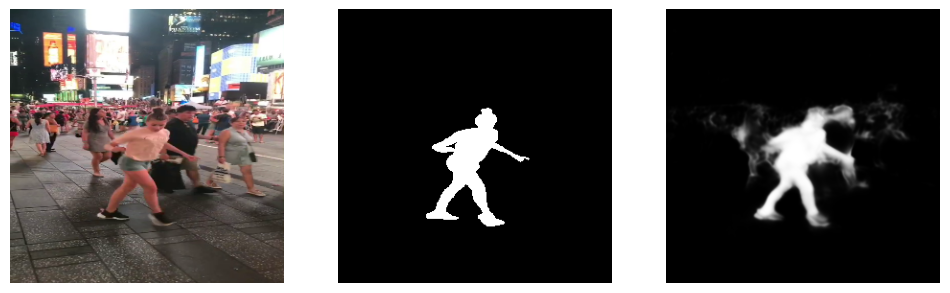

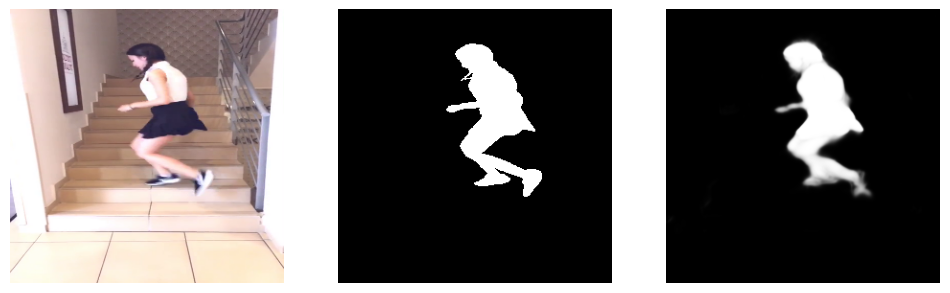

In [26]:
visualize_results(model, test_loader, 2)